# Accident Analysis in Barcelona
In this notebook, I’ll be working with accident data from the Urban Guard in Barcelona. I’ll clean the data, explore patterns through EDA, and build a modeling pipeline to understand what factors contribute to accidents.This will help uncover insights that could help improve road safety in the city


### Imports

In [ ]:
import os
import time
from collections import Counter
from pathlib import Path
from PIL import Image

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
    cross_val_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.class_weight import compute_class_weight

import geopandas as gpd

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

import optuna

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

from dotenv import load_dotenv

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from numpy.random import RandomState

from IPython.display import display

In [4]:
csv_dir = "./data/2023_accidents_causa_conductor_gu_bcn_.csv"
data = pd.read_csv(csv_dir)
data.head(5)

,Numero_expedient,Codi_districte,Nom_districte,Codi_barri,Nom_barri,Codi_carrer,Nom_carrer,Num_postal,Descripcio_dia_setmana,NK_Any,Mes_any,Nom_mes,Dia_mes,Hora_dia,Descripcio_torn,Descripcio_causa_mediata,Coordenada_UTM_X_ED50,Coordenada_UTM_Y_ED50,Longitud_WGS84,Latitud_WGS84
0,2023S000699,-1,Desconegut,-1,Desconegut,-1,Rovira (ascendent) ...,0,Dissabte,2023,2,Febrer,4,16,Tarda,Manca d'atenció a la conducció,430443.36,4585232.00,2.166596,41.413783
1,2023S005197,-1,Desconegut,-1,Desconegut,-1,Estatut de Catalunya ...,11,Divendres,2023,9,Setembre,1,13,Matí,No respectar distàncies,429493.73,4587108.15,2.155015,41.430598
2,2023S007430,-1,Desconegut,-1,Desconegut,-1,Rovira (ascendent) ...,0,Divendres,2023,12,Desembre,15,11,Matí,No respectar distàncies,430443.36,4585232.00,2.166596,41.413783
3,2023S000961,-1,Desconegut,-1,Desconegut,-1,Amílcar ...,120,Dissabte,2023,1,Gener,28,14,Tarda,No respectat pas de vianants,430955.45,4586335.10,2.172596,41.423762
4,2023S006486,-1,Desconegut,-1,Desconegut,-1,Augusta / Hort de la Vila ...,NaN,Dijous,2023,11,Novembre,2,14,Tarda,Desobeir semàfor,426883.33,4583690.92,2.124189,41.399587


## EDA

### Data cleaning

In [5]:
data.columns

Index(['Numero_expedient', 'Codi_districte', 'Nom_districte', 'Codi_barri',
       'Nom_barri', 'Codi_carrer', 'Nom_carrer', 'Num_postal ',
       'Descripcio_dia_setmana', 'NK_Any', 'Mes_any', 'Nom_mes', 'Dia_mes',
       'Hora_dia', 'Descripcio_torn', 'Descripcio_causa_mediata',
       'Coordenada_UTM_X_ED50', 'Coordenada_UTM_Y_ED50', 'Longitud_WGS84',
       'Latitud_WGS84'],
      dtype='object')

#### Typos

Num_postal has an error in the colum name

In [6]:
data.columns=data.columns.str.strip() #Num_postal with typo in the column name

This will clean any typos in the categorical columns

In [7]:
def get_categorical_columns(df):
    return df.select_dtypes(include=['object']).columns.tolist()
cat_cols=get_categorical_columns(data)

for col in cat_cols:
    if data[col].isnull().any():
        data[col] = data[col].fillna('')
    data[col] = data[col].str.strip()
    data[col] = data[col].str.replace(' ', '_')
    
print(f"Cleaned categorical columns:\n{'\n'.join(cat_cols)}")

Cleaned categorical columns:
Numero_expedient
Nom_districte
Nom_barri
Nom_carrer
Num_postal
Descripcio_dia_setmana
Nom_mes
Descripcio_torn
Descripcio_causa_mediata


In [8]:
# nom_districte has 104 rows that are 'desconegut'(unknown), I will drop them

data=data[data['Nom_districte']!='desconegut']

count_desconegut = (data['Nom_districte'] == 'desconegut').sum()
print(count_desconegut)

0


In [9]:
for col in data.columns:
    print(f'{col}: {data[col].nunique()}')

Numero_expedient: 7721
Codi_districte: 11
Nom_districte: 11
Codi_barri: 74
Nom_barri: 74
Codi_carrer: 1074
Nom_carrer: 1046
Num_postal: 1918
Descripcio_dia_setmana: 7
NK_Any: 1
Mes_any: 12
Nom_mes: 12
Dia_mes: 31
Hora_dia: 24
Descripcio_torn: 3
Descripcio_causa_mediata: 16
Coordenada_UTM_X_ED50: 4808
Coordenada_UTM_Y_ED50: 4804
Longitud_WGS84: 4821
Latitud_WGS84: 4822


codi_carrer cleaning    

In [10]:
#codi_carrer unique values: 1040. nom_carrer: unique values: 1073
data.drop('Codi_carrer', axis=1, inplace=True)


#### Duplicates

In [11]:
print(f'Duplicated rows:{data.duplicated().sum()}')
print (f'first row duplicates: {data['Numero_expedient'].duplicated().sum()}')

Duplicated rows:0
first row duplicates: 1176


In [12]:
# Some accidents have the same 'Numero_expedient' but different 'Descripcio_causa_mediata',
# so I'm keeping the first one and dropping the rest

duplicates = data.duplicated(subset=['Numero_expedient'], keep=False)

# Filtering rows that are not duplicates or that do not have 'Altres' in 'Descripcio_causa_mediata'

data = data.loc[~((data['Descripcio_causa_mediata'] == 'altres') & duplicates)]


## Data Visualization

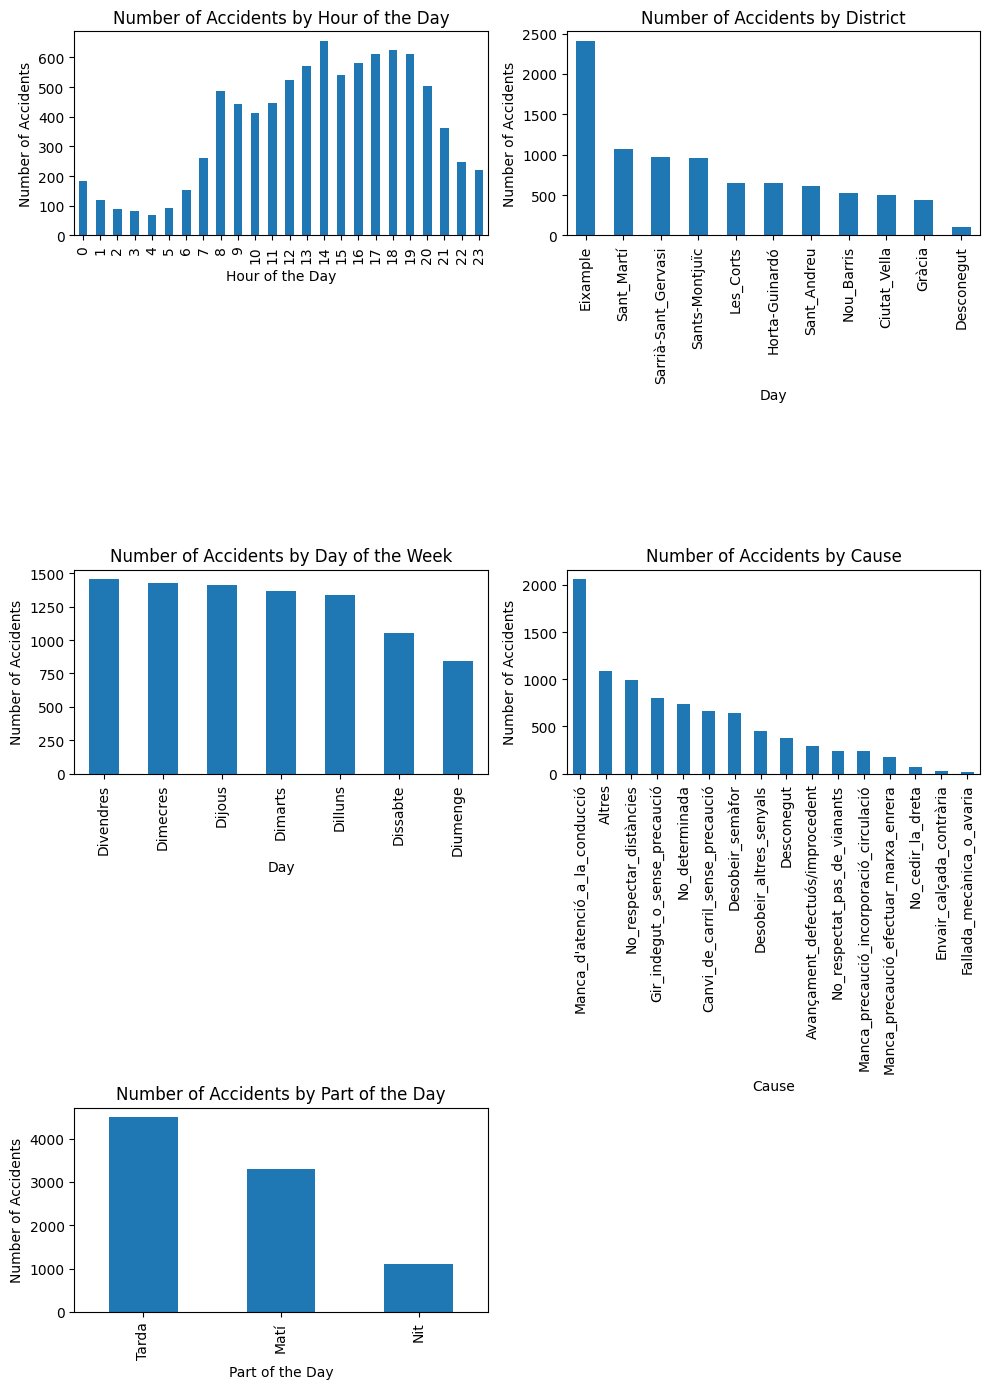

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 14))

# Plot 1: Histogram of accidents by hour of the day
data.groupby(["Hora_dia"])['Numero_expedient'].count().plot(kind="bar", ax=axes[0, 0])
axes[0, 0].set_title('Number of Accidents by Hour of the Day')
axes[0, 0].set_xlabel('Hour of the Day')
axes[0, 0].set_ylabel('Number of Accidents')

# Plot 2: Number of accidents by district
data.groupby(["Nom_districte"])['Numero_expedient'].count().sort_values(ascending=False).plot(kind="bar", ax=axes[0, 1])
axes[0, 1].set_title('Number of Accidents by District')
axes[0, 1].set_xlabel('Day')
axes[0, 1].set_ylabel('Number of Accidents')


# Plot 3: Number of accidents by day of the week
data.groupby(["Descripcio_dia_setmana"])['Numero_expedient'].count().sort_values(ascending=False).plot(kind="bar", ax=axes[1, 0])
axes[1, 0].set_title('Number of Accidents by Day of the Week')
axes[1, 0].set_xlabel('Day')
axes[1, 0].set_ylabel('Number of Accidents')

# Plot 4: Number of accidents by cause
data.groupby(["Descripcio_causa_mediata"])['Numero_expedient'].count().sort_values(ascending=False).plot(kind="bar", ax=axes[1, 1])
axes[1, 1].set_title('Number of Accidents by Cause')
axes[1, 1].set_xlabel('Cause')
axes[1, 1].set_ylabel('Number of Accidents')


#Plot 5: Number of accidents by parte of the day
data.groupby(["Descripcio_torn"])['Numero_expedient'].count().sort_values(ascending=False).plot(kind="bar", ax=axes[2, 0])
axes[2, 0].set_title('Number of Accidents by Part of the Day')
axes[2, 0].set_xlabel('Part of the Day')
axes[2, 0].set_ylabel('Number of Accidents')


# delete the last empy subplot
fig.delaxes(axes[2, 1])

# Adjust spacing between subplots
plt.tight_layout()

# Display all plots together
plt.show()


## Map View

In [14]:
# Filter out invalid or missing latitude/longitude values
data = data.dropna(subset=['Latitud_WGS84', 'Longitud_WGS84'])
data = data[(data['Latitud_WGS84'].notnull()) & (data['Longitud_WGS84'].notnull())]

# Convert to list of lists
heat_data = [[float(row['Latitud_WGS84']), float(row['Longitud_WGS84'])] for index, row in data.iterrows()]

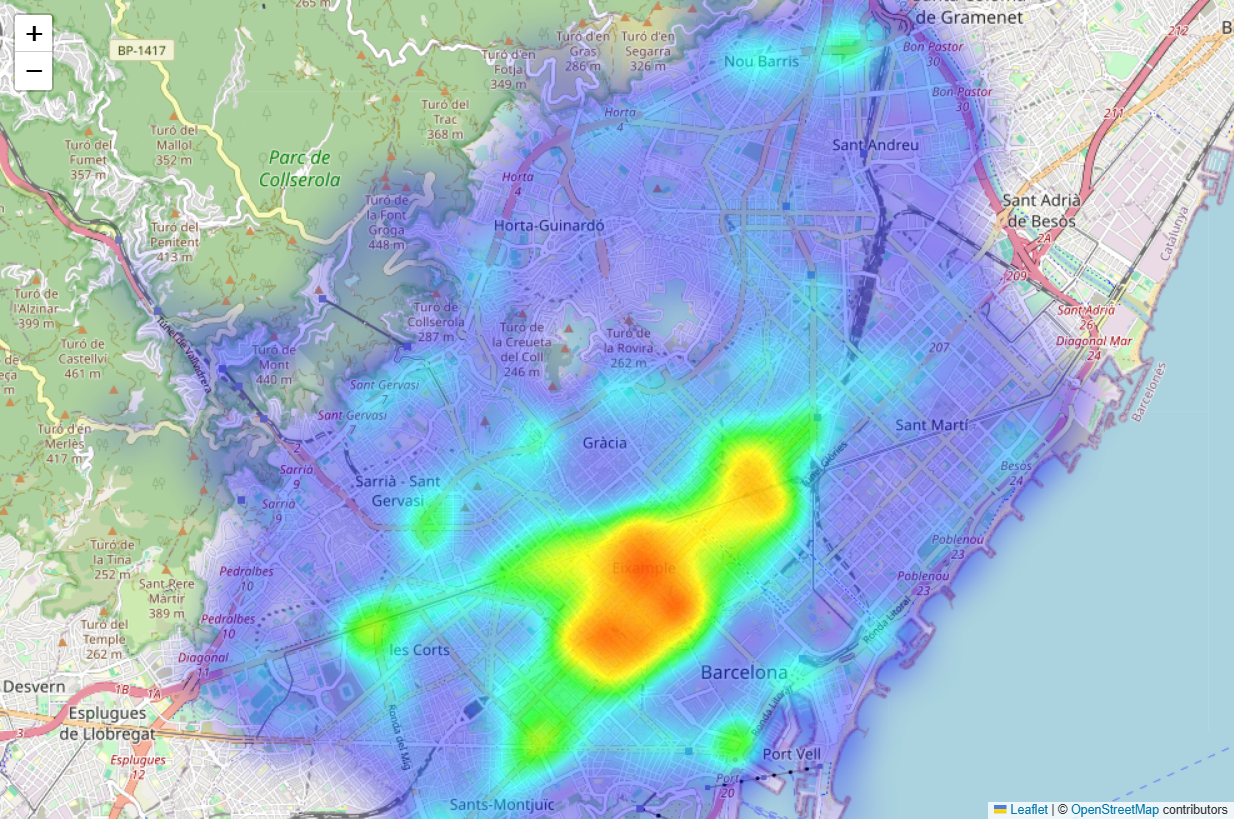

In [ ]:
# Create a folium map 
barcelona_map = folium.Map(location=[41.41, 2.16], zoom_start=12.5)

# Add the heatmap layer
HeatMap(heat_data, blur=30, min_opacity=0.2).add_to(barcelona_map)
barcelona_map.save("barcelona_heatmap.html")

def render_folium_map(map_object, html_path, png_path, width=1000, height=800, wait_time=5):
    """
    Render a Folium map as a static image and save both HTML and PNG versions.
    
    Parameters:
    - map_object: A Folium map object
    - html_path: Path to save the HTML version of the map
    - png_path: Path to save the PNG version of the map
    - width: Width of the browser window (default 1000)
    - height: Height of the browser window (default 800)
    - wait_time: Time to wait for the map to render in seconds (default 5)
    
    Returns:
    - Displays the PNG image in the notebook
    """
    # change routes to path for compability
    html_path = Path(html_path).resolve()
    png_path = Path(png_path).resolve()
    
    # Save the map to the specified HTML file
    map_object.save(html_path)
    
    # Set up the web driver
    options = Options()
    options.add_argument('--headless')  # Run in background
    options.add_argument('--disable-gpu')  # Disable GPU for headless mode
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    
    try:
        # Open the HTML file
        driver.get(f"file://{html_path}")
        
        # Wait for the map to render
        time.sleep(wait_time)
        
        # Set the size of the browser window
        driver.set_window_size(width, height)
        
        # Capture the screenshot
        driver.save_screenshot(png_path)
        
        # Display the image in the notebook
        
        display(Image.open(png_path))

    finally:
        # Close the browser
        driver.quit()

# Call the function
render_folium_map(barcelona_map, "data/barcelona_heatmap.html", "data/barcelona_heatmap.png")
       

---
# Insight Analysis

We can see that **Eixample** is the district with the most accidents, and within it, the neighborhood **La Dreta de Eixample** leads the chart.

Additionally, there is a noticeable trend of an increase in the number of accidents during specific hours, mainly between **2:00 PM and 8:00 PM**.

Regarding the cause, **lack of attention while driving** is the leading cause of accidents.

There doesn’t seem to be a significant difference in the number of accidents by day of the week, except for a decrease on **Saturdays and Sundays**.




### Explanation for Choosing a Classification

I decided to approach this problem as a classification task rather than a time series prediction because the target variable represents 

categorical accident. These do not follow a clear temporal evolution but instead depend on multiple static and contextual factors, such as 

location, day of the week, time of day, and other categorical and numerical features.

In [ ]:

def create_time_features(df):
    """
    Generates time-based features from the dataset.
    
    Features created:
    - Cyclic encoding for the hour of the day using sine and cosine transformations.
    - Binary feature indicating whether the day is a weekend.
    
    Args:
        df (pd.DataFrame): Input dataframe containing a 'Hora_dia' column.
    
    Returns:
        pd.DataFrame: Dataframe with added time-based features.
    """
    df['hora_sin'] = np.sin(2 * np.pi * df['Hora_dia'] / 24)
    df['hora_cos'] = np.cos(2 * np.pi * df['Hora_dia'] / 24)
    df['es_fin_semana'] = df['Descripcio_dia_setmana'].isin(['Dissabte', 'Diumenge']).astype(int)
    
    return df

def prepare_features(df):
    """
    Prepares features for model training by encoding categorical variables and scaling numerical features.
    
    Steps:
    1. Adds time-based features.
    2. Defines categorical and numerical feature lists.
    3. Encodes categorical features using Label Encoding.
    4. Scales numerical features using StandardScaler.
    5. Encodes target variable using Label Encoding.
    6. Prints the class distribution.
    
    Args:
        df (pd.DataFrame): Input dataframe containing raw features.
    
    Returns:
        Tuple:
            - X_encoded (pd.DataFrame): Processed feature set.
            - y (np.array): Encoded target variable.
            - categorical_features (list): List of categorical feature names.
            - le_y (LabelEncoder): LabelEncoder fitted on the target variable.
    """
    df = create_time_features(df)

    categorical_features = ['Nom_districte', 'Nom_barri', 'Descripcio_dia_setmana', 'Nom_mes', 'Descripcio_torn']
    numeric_features = ['Hora_dia', 'Dia_mes', 'Mes_any', 'Coordenada_UTM_X_ED50', 'Coordenada_UTM_Y_ED50', 
                        'hora_sin', 'hora_cos', 'es_fin_semana']

    X = df[categorical_features + numeric_features].copy()
    y = df['Descripcio_causa_mediata'].copy()

    # Encoding categorical features
    X_encoded = X.copy()
    for cat_col in categorical_features:
        le = LabelEncoder()
        X_encoded[cat_col] = le.fit_transform(X[cat_col])

    # Scaling numerical features
    scaler = StandardScaler()
    X_encoded[numeric_features] = scaler.fit_transform(X_encoded[numeric_features])

    # Encoding target variable
    le_y = LabelEncoder()
    y = le_y.fit_transform(y)

    print("\nClass distribution:")
    print(pd.Series(y).value_counts().sort_index())

    return X_encoded, y, categorical_features, le_y

def objective(trial, X, y, categorical_features):
    """
    Defines the objective function for hyperparameter optimization using Optuna.
    
    Steps:
    1. Suggests values for LightGBM hyperparameters.
    2. Uses StratifiedKFold for cross-validation.
    3. Balances the training data using SMOTE.
    4. Trains a LightGBM model and evaluates using ROC AUC.
    
    Args:
        trial (optuna.Trial): Optuna trial object.
        X (pd.DataFrame): Training features.
        y (np.array): Target variable.
        categorical_features (list): List of categorical feature names.
    
    Returns:
        float: Mean ROC AUC score across validation folds.
    """
    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_class': len(np.unique(y)),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'is_unbalance': True
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

        model = lgb.LGBMClassifier(**params, random_state=42)
        model.fit(
            X_train_res, y_train_res,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(stopping_rounds=20)]
        )

        pred = model.predict_proba(X_val)
        score = roc_auc_score(y_val, pred, multi_class='ovr')
        scores.append(score)

    return np.mean(scores)

def train_and_evaluate_models_fast(X, y, categorical_features):
    """
    Trains and evaluates a LightGBM model using Optuna for hyperparameter tuning.
    
    Steps:
    1. Splits data into training and test sets (stratified).
    2. Applies SMOTE-Tomek to balance training data.
    3. Optimizes hyperparameters with Optuna.
    4. Trains final model using best hyperparameters.
    5. Evaluates model performance and returns metrics.
    
    Args:
        X (pd.DataFrame): Feature set.
        y (np.array): Target variable.
        categorical_features (list): List of categorical features.
    
    Returns:
        Tuple: 
            - results (dict): Model, classification report, confusion matrix, feature importance, ROC AUC.
            - X_train, X_test, y_train, y_test (splitted data).
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("\nApplying SMOTE-Tomek for class balancing...")
    smt = SMOTETomek(random_state=42)
    X_train_res, y_train_res = smt.fit_resample(X_train, y_train)
    
    print("\nOptimizing hyperparameters...")
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_train_res, y_train_res, categorical_features), n_trials=20)

    best_params = study.best_params
    print("\nBest hyperparameters:", best_params)

    final_model = lgb.LGBMClassifier(
        **best_params, random_state=42, verbose=-1, objective='multiclass', num_class=len(np.unique(y))
    )

    final_model.fit(X_train_res, y_train_res, eval_set=[(X_test, y_test)], 
                    callbacks=[lgb.early_stopping(stopping_rounds=20)])

    y_pred = final_model.predict(X_test)
    y_pred_proba = final_model.predict_proba(X_test)

    results = {
        'model': final_model,
        'classification_report': classification_report(y_test, y_pred, zero_division=0),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'feature_importance': pd.DataFrame({'feature': X.columns, 'importance': final_model.feature_importances_})
                              .sort_values('importance', ascending=False),
        'best_params': best_params,
        'roc_auc': roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    }

    return results, X_train, X_test, y_train, y_test

def main_pipeline(df):
    """
    Main pipeline function to preprocess data, train model, and evaluate performance.
    """
    print("Starting classification pipeline...")

    required_columns = [...]  # List of required columns
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing columns: {missing_columns}")

    print("\nPreparing features...")
    X, y, categorical_features, le_y = prepare_features(df)

    print("\nTraining and evaluating model...")
    return train_and_evaluate_models_fast(X, y, categorical_features) + (le_y,)


In [52]:
results, X_train, X_test, y_train, y_test, le_y = main_pipeline(data)

Iniciando pipeline de clasificación...

Preparando características...

Distribución de clases:
0     1089
1      296
2      666
3      377
4      457
5      640
6       25
7       15
8      804
9     2061
10     177
11     238
12      72
13     743
14     996
15     241
Name: count, dtype: int64

Entrenando y evaluando modelo...

Aplicando SMOTE-Tomek para balance de clases...


[I 2025-03-11 13:12:23,800] A new study created in memory with name: no-name-5370e08b-c776-4bcf-9d6b-a79a8e654949


Distribución de clases original: Counter({9: 1649, 0: 871, 14: 797, 8: 643, 13: 594, 2: 533, 5: 512, 4: 365, 3: 301, 1: 237, 15: 193, 11: 190, 10: 142, 12: 58, 6: 20, 7: 12})
Distribución después de SMOTE-Tomek: Counter({6: 1649, 7: 1647, 12: 1646, 10: 1640, 15: 1631, 11: 1622, 1: 1619, 3: 1605, 4: 1603, 5: 1581, 2: 1574, 0: 1571, 8: 1567, 14: 1555, 13: 1553, 9: 1485})

Optimizando hiperparámetros...
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 2.02934
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 2.04078
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 2.03414
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 2.03758
Trai

[I 2025-03-11 13:12:39,134] Trial 0 finished with value: 0.8541682654605163 and parameters: {'learning_rate': 0.014367755999913023, 'num_leaves': 36, 'max_depth': 7, 'min_child_samples': 80, 'subsample': 0.9097191558405194, 'colsample_bytree': 0.8834633682991007, 'reg_alpha': 2.94593033320087, 'reg_lambda': 0.025359716166934505}. Best is trial 0 with value: 0.8541682654605163.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.62947
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.65123
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.62848
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.62971
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.63188


[I 2025-03-11 13:12:50,684] Trial 1 finished with value: 0.8909465043763323 and parameters: {'learning_rate': 0.08900411962371353, 'num_leaves': 67, 'max_depth': 5, 'min_child_samples': 62, 'subsample': 0.9454368484824154, 'colsample_bytree': 0.7285576652054511, 'reg_alpha': 0.12943751794820763, 'reg_lambda': 0.2804069410560361}. Best is trial 1 with value: 0.8909465043763323.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.69972
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.70649
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.69994
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.70359
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.69784


[I 2025-03-11 13:13:04,344] Trial 2 finished with value: 0.8851681331714886 and parameters: {'learning_rate': 0.05691701780835067, 'num_leaves': 24, 'max_depth': 6, 'min_child_samples': 76, 'subsample': 0.9197346035069223, 'colsample_bytree': 0.6573518265601666, 'reg_alpha': 0.7313619695099909, 'reg_lambda': 0.00020248484736684825}. Best is trial 1 with value: 0.8909465043763323.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.52122
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.54358
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.50948
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.51513
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.52302


[I 2025-03-11 13:13:26,462] Trial 3 finished with value: 0.912329098243333 and parameters: {'learning_rate': 0.04456742059486836, 'num_leaves': 77, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.7543919181527158, 'colsample_bytree': 0.7602396949061786, 'reg_alpha': 0.0006565041929716004, 'reg_lambda': 0.3908191301869625}. Best is trial 3 with value: 0.912329098243333.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.32446
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.36418
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.33256
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.33476
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.33208


[I 2025-03-11 13:13:58,849] Trial 4 finished with value: 0.9229639969288032 and parameters: {'learning_rate': 0.09256916703460179, 'num_leaves': 48, 'max_depth': 7, 'min_child_samples': 58, 'subsample': 0.9971207838452145, 'colsample_bytree': 0.6632553343289455, 'reg_alpha': 7.325011718937155e-08, 'reg_lambda': 1.5028633024870516e-05}. Best is trial 4 with value: 0.9229639969288032.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.4582
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.47188
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.44295
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.45666
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.45818


[I 2025-03-11 13:14:31,875] Trial 5 finished with value: 0.9139122908876951 and parameters: {'learning_rate': 0.07135225962989242, 'num_leaves': 83, 'max_depth': 7, 'min_child_samples': 77, 'subsample': 0.9604158699527504, 'colsample_bytree': 0.6510872267406704, 'reg_alpha': 2.4062731530133474e-05, 'reg_lambda': 4.785739652895012e-07}. Best is trial 4 with value: 0.9229639969288032.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.52311
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.5415
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.51983
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.52581
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.52264


[I 2025-03-11 13:15:04,115] Trial 6 finished with value: 0.9046930876968972 and parameters: {'learning_rate': 0.06424331598546018, 'num_leaves': 30, 'max_depth': 8, 'min_child_samples': 39, 'subsample': 0.6356877681905416, 'colsample_bytree': 0.9711236573371643, 'reg_alpha': 3.762917752442121e-08, 'reg_lambda': 3.1715338421729786}. Best is trial 4 with value: 0.9229639969288032.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 2.13845
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 2.16801
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 2.14976
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 2.15094
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 2.14956


[I 2025-03-11 13:15:25,275] Trial 7 finished with value: 0.8175828050876236 and parameters: {'learning_rate': 0.027749347316767106, 'num_leaves': 32, 'max_depth': 4, 'min_child_samples': 62, 'subsample': 0.9868190933574024, 'colsample_bytree': 0.9299701246511212, 'reg_alpha': 0.0002832537373908046, 'reg_lambda': 1.0451359312385665e-05}. Best is trial 4 with value: 0.9229639969288032.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 2.30471
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 2.32557
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 2.31277
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 2.31425
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 2.31255


[I 2025-03-11 13:15:41,687] Trial 8 finished with value: 0.7807382636822071 and parameters: {'learning_rate': 0.027281007004410912, 'num_leaves': 73, 'max_depth': 3, 'min_child_samples': 26, 'subsample': 0.7852016799877274, 'colsample_bytree': 0.7786336993123505, 'reg_alpha': 0.6404607832933106, 'reg_lambda': 0.0023776557897762854}. Best is trial 4 with value: 0.9229639969288032.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.09594
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.13386
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.09553
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.09228
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.10055


[I 2025-03-11 13:16:26,966] Trial 9 finished with value: 0.9412005404256172 and parameters: {'learning_rate': 0.09890316818872268, 'num_leaves': 80, 'max_depth': 11, 'min_child_samples': 49, 'subsample': 0.9605763009440698, 'colsample_bytree': 0.6476320751420531, 'reg_alpha': 0.00023056695465417621, 'reg_lambda': 1.459712561210305e-05}. Best is trial 9 with value: 0.9412005404256172.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.03857
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.08532
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.0549
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.05073
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.06582


[I 2025-03-11 13:17:20,650] Trial 10 finished with value: 0.9439925806266665 and parameters: {'learning_rate': 0.09990737826449994, 'num_leaves': 100, 'max_depth': 12, 'min_child_samples': 40, 'subsample': 0.8455336536646305, 'colsample_bytree': 0.6027740376154467, 'reg_alpha': 1.3231997398684172e-06, 'reg_lambda': 1.3903572597549798e-08}. Best is trial 10 with value: 0.9439925806266665.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.04641
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.09658
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.0594
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.04954
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.06664


[I 2025-03-11 13:18:13,887] Trial 11 finished with value: 0.9435749069444943 and parameters: {'learning_rate': 0.09866237775809912, 'num_leaves': 99, 'max_depth': 12, 'min_child_samples': 37, 'subsample': 0.8702206013397117, 'colsample_bytree': 0.6060582616467199, 'reg_alpha': 3.4764438439953e-06, 'reg_lambda': 1.2850961599559e-08}. Best is trial 10 with value: 0.9439925806266665.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.04779
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.09943
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.05311
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.05175
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.07042


[I 2025-03-11 13:19:12,051] Trial 12 finished with value: 0.9445840990750727 and parameters: {'learning_rate': 0.08034303167150832, 'num_leaves': 98, 'max_depth': 12, 'min_child_samples': 37, 'subsample': 0.8605946375593896, 'colsample_bytree': 0.8478151470055838, 'reg_alpha': 1.8479458989585937e-06, 'reg_lambda': 1.1601200491716996e-08}. Best is trial 12 with value: 0.9445840990750727.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.0817
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.12171
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.08075
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.08436
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.09554


[I 2025-03-11 13:20:09,839] Trial 13 finished with value: 0.9426623246740784 and parameters: {'learning_rate': 0.0811123135046218, 'num_leaves': 100, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.8524301729587381, 'colsample_bytree': 0.8534121132240443, 'reg_alpha': 1.399363187377892e-06, 'reg_lambda': 4.4821490166840125e-08}. Best is trial 12 with value: 0.9445840990750727.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.09747
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.1453
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.10228
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.09989
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.11288


[I 2025-03-11 13:20:41,400] Trial 14 finished with value: 0.9407158700399186 and parameters: {'learning_rate': 0.07987162598592427, 'num_leaves': 91, 'max_depth': 10, 'min_child_samples': 13, 'subsample': 0.7249360499527377, 'colsample_bytree': 0.8128749463433136, 'reg_alpha': 7.736503585258189e-07, 'reg_lambda': 2.892594721178925e-07}. Best is trial 12 with value: 0.9445840990750727.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.18941
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.21222
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.18589
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.17565
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.20353


[I 2025-03-11 13:21:01,277] Trial 15 finished with value: 0.9359143124151575 and parameters: {'learning_rate': 0.07910549948253569, 'num_leaves': 56, 'max_depth': 12, 'min_child_samples': 94, 'subsample': 0.8404949293263105, 'colsample_bytree': 0.841289995376268, 'reg_alpha': 0.013646842232360769, 'reg_lambda': 4.853241852408312e-07}. Best is trial 12 with value: 0.9445840990750727.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.35774
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.38733
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.34206
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.35256
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.35382


[I 2025-03-11 13:21:25,370] Trial 16 finished with value: 0.9275063275250728 and parameters: {'learning_rate': 0.045728801555463015, 'num_leaves': 87, 'max_depth': 9, 'min_child_samples': 47, 'subsample': 0.6995170973660626, 'colsample_bytree': 0.7375103200745281, 'reg_alpha': 1.7286777369543367e-05, 'reg_lambda': 1.0106851578471403e-08}. Best is trial 12 with value: 0.9445840990750727.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.04359
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.09371
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.05737
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.05086
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.07112


[I 2025-03-11 13:21:56,878] Trial 17 finished with value: 0.9442233532819984 and parameters: {'learning_rate': 0.08776385707411133, 'num_leaves': 92, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.8054332976117792, 'colsample_bytree': 0.9055565873038189, 'reg_alpha': 1.742460956116951e-07, 'reg_lambda': 1.4106649802234418e-07}. Best is trial 12 with value: 0.9445840990750727.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.21347
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.24437
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.20048
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.21438
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.21519


[I 2025-03-11 13:22:23,894] Trial 18 finished with value: 0.9347721626140144 and parameters: {'learning_rate': 0.06513569457408191, 'num_leaves': 64, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.7909560894518309, 'colsample_bytree': 0.9219876560360407, 'reg_alpha': 1.1157978617016477e-07, 'reg_lambda': 2.304518941590031e-06}. Best is trial 12 with value: 0.9445840990750727.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.04646
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.0988
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.05668
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.04938
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.06875


[I 2025-03-11 13:22:55,064] Trial 19 finished with value: 0.9437133667102138 and parameters: {'learning_rate': 0.0865239726682019, 'num_leaves': 91, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.670114876666416, 'colsample_bytree': 0.9709459626048379, 'reg_alpha': 2.5425625697716787e-08, 'reg_lambda': 8.612785604217558e-05}. Best is trial 12 with value: 0.9445840990750727.



Mejores hiperparámetros: {'learning_rate': 0.08034303167150832, 'num_leaves': 98, 'max_depth': 12, 'min_child_samples': 37, 'subsample': 0.8605946375593896, 'colsample_bytree': 0.8478151470055838, 'reg_alpha': 1.8479458989585937e-06, 'reg_lambda': 1.1601200491716996e-08}
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's multi_logloss: 2.5524


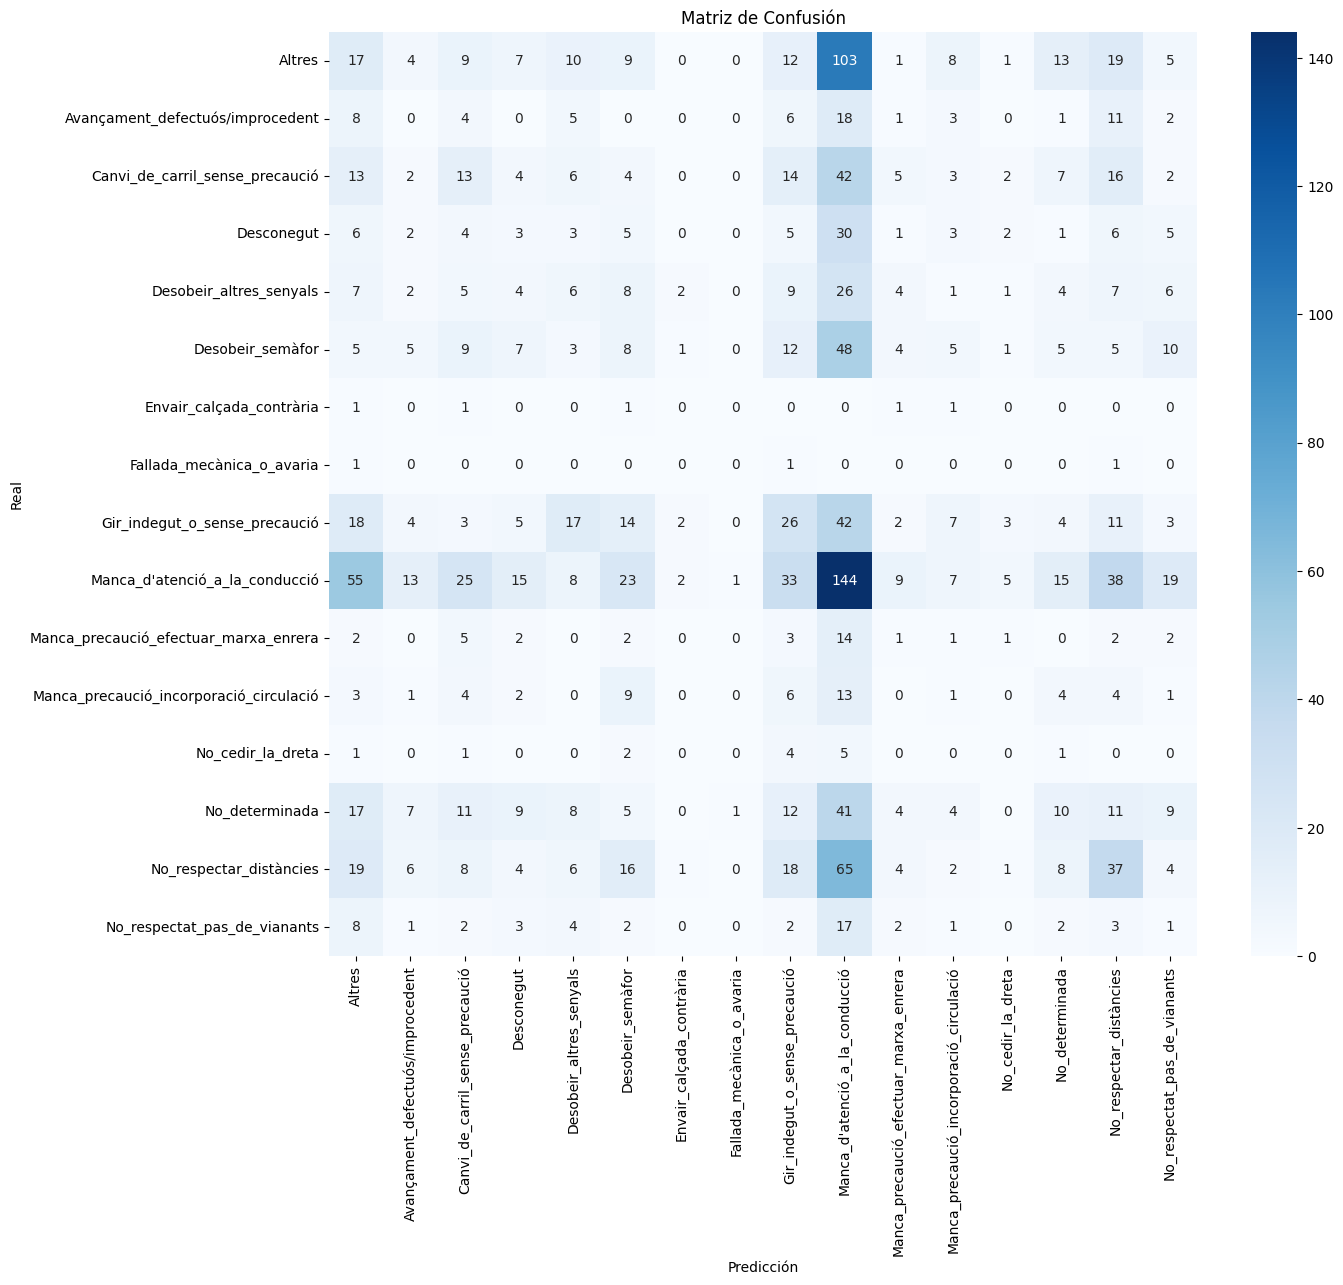

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.09      0.08      0.09       218
           1       0.00      0.00      0.00        59
           2       0.12      0.10      0.11       133
           3       0.05      0.04      0.04        76
           4       0.08      0.07      0.07        92
           5       0.07      0.06      0.07       128
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         3
           8       0.16      0.16      0.16       161
           9       0.24      0.35      0.28       412
          10       0.03      0.03      0.03        35
          11       0.02      0.02      0.02        48
          12       0.00      0.00      0.00        14
          13       0.13      0.07      0.09       149
          14       0.22      0.19      0.20       199
          15       0.01      0.02      0.02        48

    accuracy                           0.15      1780


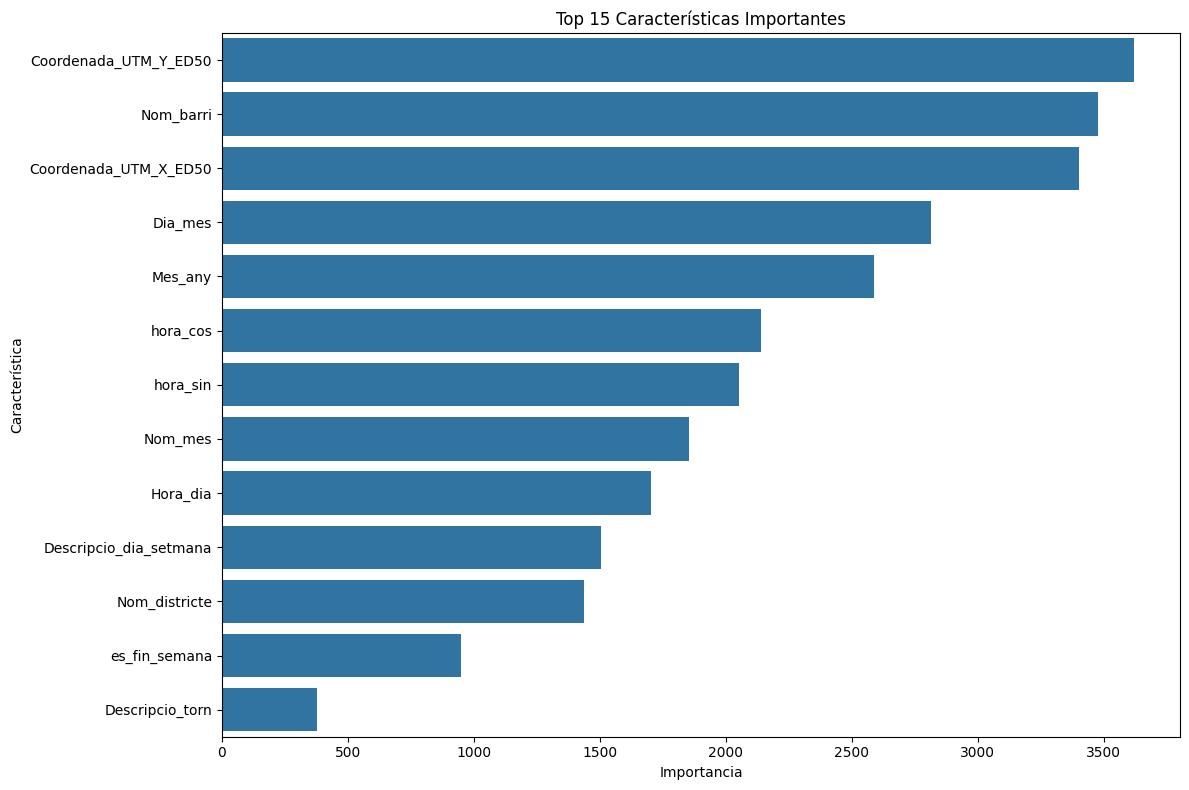

ROC-AUC Score: 0.5553

Rendimiento en clases minoritarias:
Clase 6 (Envair_calçada_contrària): 0/5 correctas (0.00%)
Clase 7 (Fallada_mecànica_o_avaria): 0/3 correctas (0.00%)
Clase 12 (No_cedir_la_dreta): 0/14 correctas (0.00%)

Mejores hiperparámetros:
learning_rate: 0.08034303167150832
num_leaves: 98
max_depth: 12
min_child_samples: 37
subsample: 0.8605946375593896
colsample_bytree: 0.8478151470055838
reg_alpha: 1.8479458989585937e-06
reg_lambda: 1.1601200491716996e-08


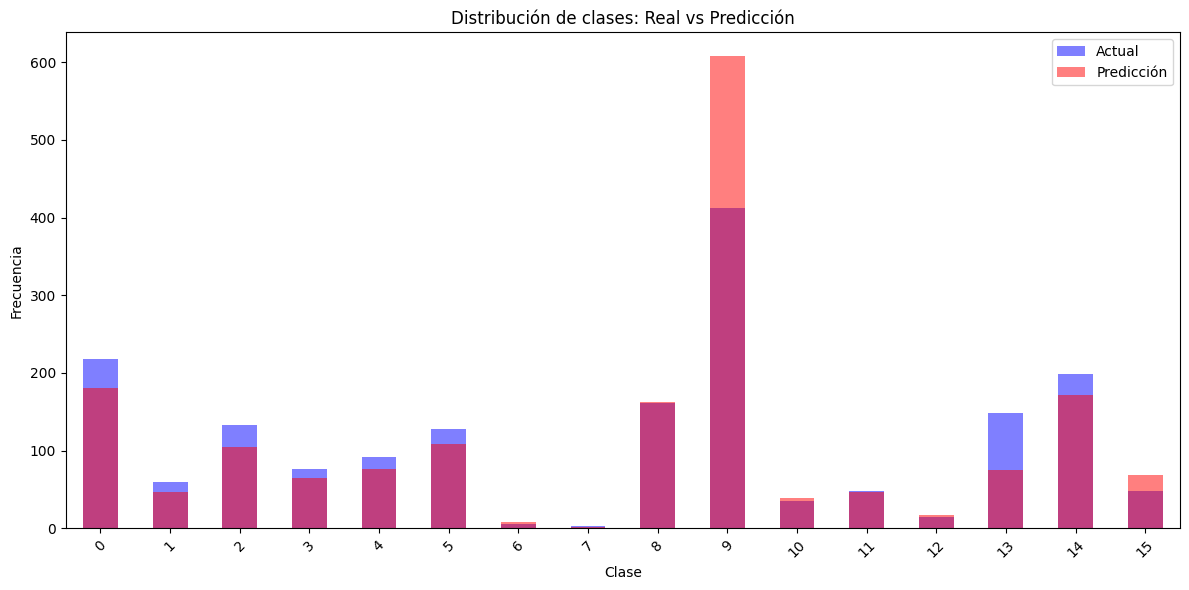

In [53]:
# 1. Visualizar la matriz de confusión
plt.figure(figsize=(14, 12))
cm = results['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# 2. Visualizar el reporte de clasificación
print("Reporte de Clasificación:")
print(results['classification_report'])

# 3. Visualizar las características más importantes
n_features = 15  # Top 15 características
importance_df = results['feature_importance'].head(n_features)
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Top 15 Características Importantes')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# 4. Visualizar ROC-AUC por clase
print(f"ROC-AUC Score: {results['roc_auc']:.4f}")

# 5. Analizar rendimiento en clases minoritarias
# Identificar clases minoritarias en el conjunto original
class_counts = pd.Series(y_train).value_counts().sort_index()
print("\nRendimiento en clases minoritarias:")
for cls in class_counts[class_counts < 100].index:
    class_name = le_y.inverse_transform([cls])[0]
    class_idx = np.where(y_test == cls)[0]
    if len(class_idx) > 0:
        correct = (y_test[class_idx] == results['model'].predict(X_test.iloc[class_idx])).sum()
        print(f"Clase {cls} ({class_name}): {correct}/{len(class_idx)} correctas ({correct/len(class_idx)*100:.2f}%)")

# 6. Visualizar hiperparámetros óptimos
print("\nMejores hiperparámetros:")
for param, value in results['best_params'].items():
    print(f"{param}: {value}")

# 7. Visualizar distribución de predicciones vs reales
plt.figure(figsize=(12, 6))
pd.Series(y_test, name="Actual").value_counts().sort_index().plot(kind='bar', alpha=0.5, color='blue', label='Actual')
pd.Series(results['model'].predict(X_test), name="Predicción").value_counts().sort_index().plot(kind='bar', alpha=0.5, color='red', label='Predicción')
plt.title('Distribución de clases: Real vs Predicción')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion
The analysis shows significant challenges in predictive modeling for this problem. The model achieved an accuracy of 18% and an ROC-AUC score of 0.5698, indicating limited predictive power. UTM coordinates and neighborhood were the most influential predictors, so location plays a crucial role in determining accident causes. Temporal variables such as day of month, month of year, and time of day also showed to be important. The confusion matrix highlights a bias toward majority classes, specifically "lack of attention while driving," while minority classes remain poorly predicted despite balancing techniques. This demonstrates the inherent complexity of traffic accident causality and suggests that further feature engineering, class rebalancing strategies, or more sophisticated modeling approaches may be necessary to improve predictive performance. Nevertheless, the current model provides valuable insights into spatial and temporal patterns of accident causes that could inform targeted road safety interventions.